# SmartAPI KG Exporting 

In [1]:
import warnings
import tempfile
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import xml.etree.ElementTree as ET

from controller import SmartAPI
from IPython.display import display

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

### Steps:
1. [Get MetaKG API w/ and ID](#get)  
2. [Clean the data for KG import](#clean)    
3. [Setup the KG](#setup)  
4. [Write to XML file](#write)   


### Get MetaKG API <a name="get"></a>  
Will set this up as the initial response in the API endpoint

### 

In [2]:
bte = SmartAPI.get("dc91716f44207d2e1287c727f281d339")
mkg = bte.get_metakg()
mkg_df = pd.DataFrame(mkg)


In [3]:
mkg_df.sample()

,subject,object,predicate,provided_by,api,bte
164,SmallMolecule,Protein,correlated_with,None,"{'name': 'BioThings Explorer (BTE) TRAPI', 'smartapi': {'metadata': 'https://raw.githubusercontent.com/NCATS-Tangerine/translator-api-registry/master/biothings_explorer/smartapi.yaml', 'id': 'dc91716f44207d2e1287c727f281d339', 'ui': 'https://smart-api.info/ui/dc91716f44207d2e1287c727f281d339'}, 'tags': ['1.3.0', 'meta_knowledge_graph', 'query', 'asyncquery', 'translator', 'trapi', 'biothings', 'bte-trapi'], 'x-translator': {'component': 'ARA', 'team': ['Exploring Agent']}}","{'query_operation': {'path': '/query', 'method': 'post', 'server': 'https://bte.transltr.io/v1', 'path_params': None, 'params': None, 'request_body': None, 'support_batch': True, 'input_separator': ','}}"


In [4]:
for data in mkg[:10]:
    print(data['predicate'])

is_sequence_variant_of
is_non_coding_variant_of
is_splice_site_variant_of
is_synonymous_variant_of
related_to
is_nearby_variant_of
is_frameshift_variant_of
is_missense_variant_of
affects
is_nonsense_variant_of


### Clean the dataframe for graph input <a name="clean"></a>  
We only need to keep the subject/object/predicate. 

In [7]:
mkg_df.drop(["provided_by"], axis=1, inplace=True)
mkg_df.drop(["api"], axis=1, inplace=True)
mkg_df.drop(["bte"], axis=1, inplace=True)

In [8]:
mkg_df.sample()

,subject,object,predicate
908,Procedure,Procedure,affects


In [9]:
mkg_df["predicate"].unique()

array(['is_sequence_variant_of', 'is_non_coding_variant_of',
       'is_splice_site_variant_of', 'is_synonymous_variant_of',
       'related_to', 'is_nearby_variant_of', 'is_frameshift_variant_of',
       'is_missense_variant_of', 'affects', 'is_nonsense_variant_of',
       'contributes_to', 'has_phenotype', 'has_adverse_event', 'treats',
       'causes', 'prevents', 'predisposes', 'disrupts', 'produced_by',
       'exacerbates', 'part_of', 'associated_with',
       'occurs_together_in_literature_with', 'contraindicated_for',
       'positively_correlated_with', 'negatively_correlated_with',
       'correlated_with', 'biomarker_for', 'ameliorates',
       'interacts_with', 'coexists_with', 'affected_by', 'derives_into',
       'derives_from', 'has_part', 'produces', 'subclass_of',
       'similar_to', 'participates_in', 'physically_interacts_with',
       'sensitivity_associated_with', 'resistance_associated_with',
       'has_target', 'directly_physically_interacts_with', 'regulates',

### Setup the KG with a networkx <a name="setup"></a>

In [10]:
import networkx as nx

Using the dataframe we created above, `mkg_df`, we can directly create a graph by importing a pandas dataframe into the networkx function.

In [11]:
# create a directed graph  -- all available relations 
G1=nx.from_pandas_edgelist(mkg_df, "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

In [12]:
# create a directed graph  -- one relation
G2=nx.from_pandas_edgelist(mkg_df[mkg_df['predicate']=='derives_from'], "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

In [13]:
# create a directed graph  -- one relation
G3=nx.from_pandas_edgelist(mkg_df[mkg_df['predicate']=='is_diagnosed_by'], "subject", "object", edge_attr=True,create_using=nx.MultiDiGraph())

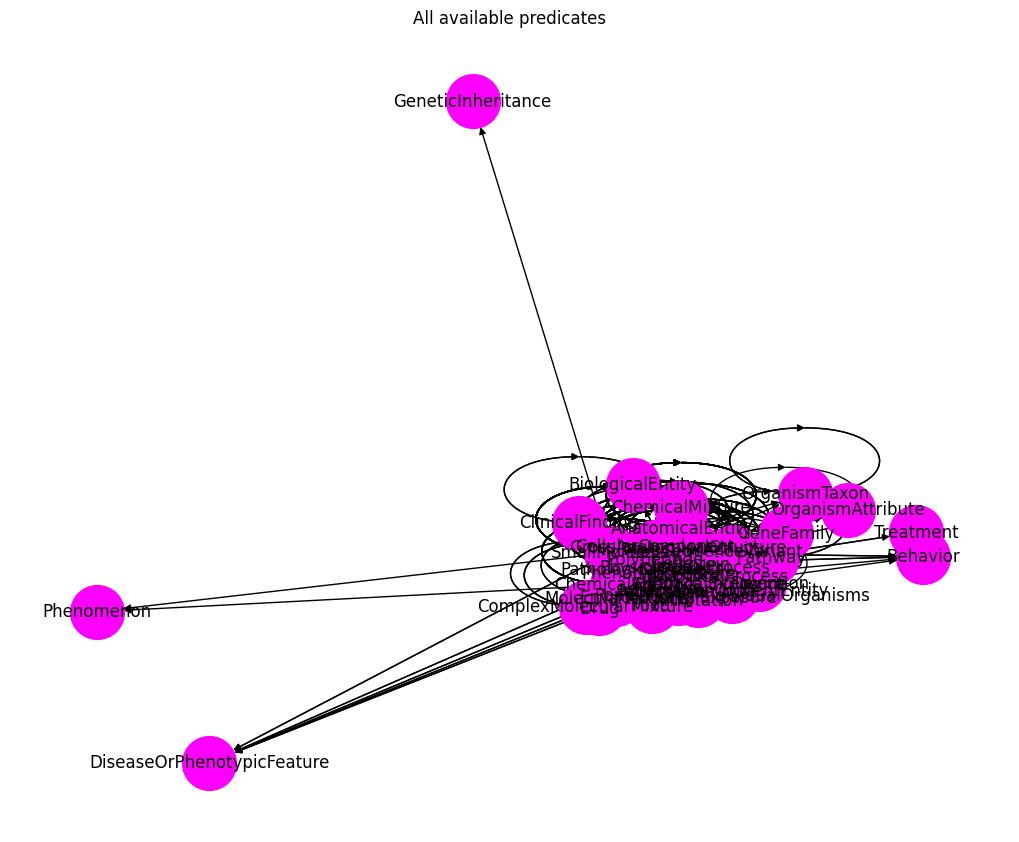

In [14]:
pos = nx.spring_layout(G1)
plt.figure(figsize=(10,8))
nx.draw(G1, with_labels=True, node_color='magenta', node_size=1500, edge_cmap=plt.cm.Blues)#, pos = pos)
plt.title("All available predicates")
plt.show()

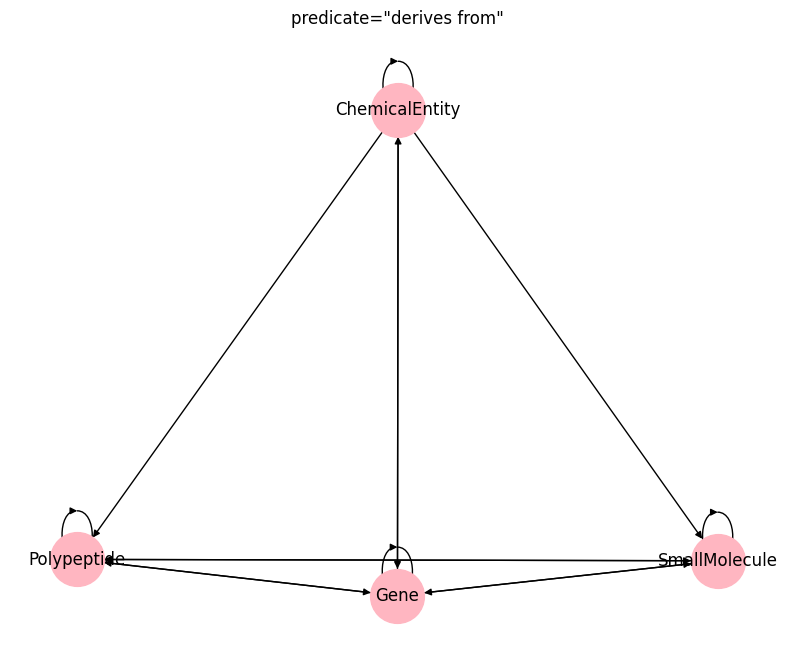

In [13]:
# pos = nx.spring_layout(G2, k = 0.5) # k regulates the distance between nodes
plt.figure(figsize=(10,8))
plt.title('predicate="derives from"')
nx.draw(G2, with_labels=True, node_color='lightpink', node_size=1500)#, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()


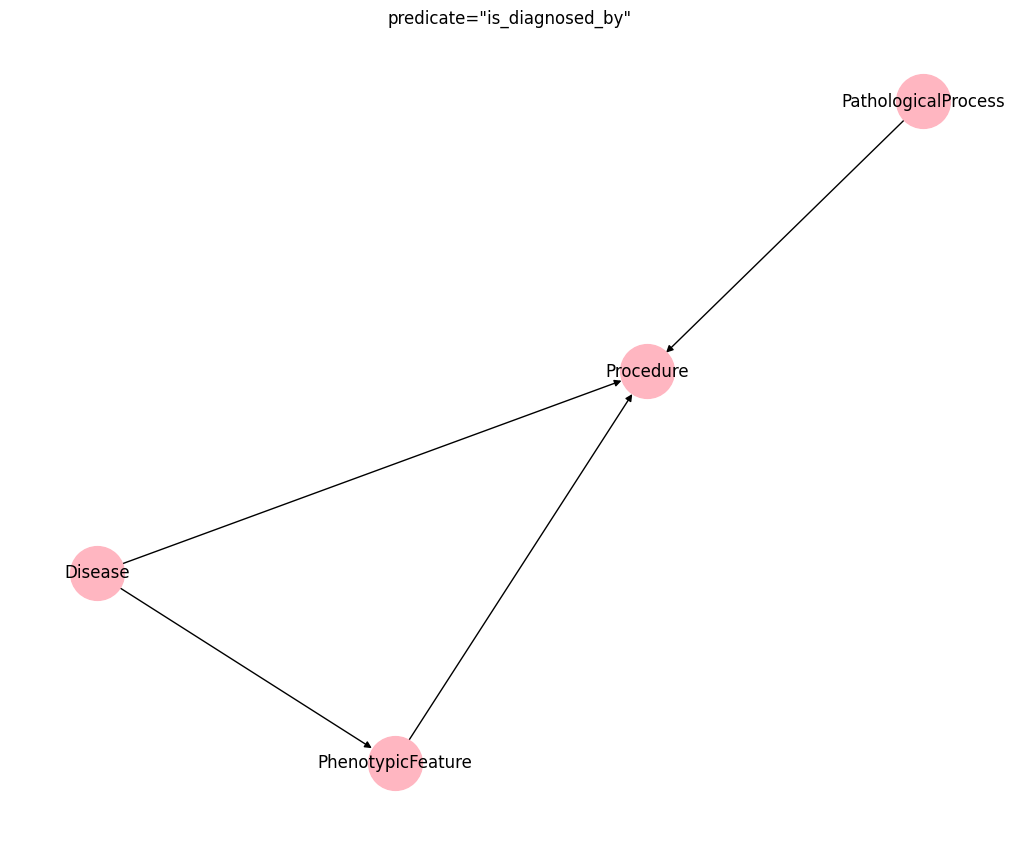

In [14]:
# pos = nx.spring_layout(G3, k = 0.5) # k regulates the distance between nodes
plt.figure(figsize=(10,8))
nx.draw(G3, with_labels=True, node_color='lightpink', node_size=1500, edge_cmap=plt.cm.Blues)
plt.title('predicate="is_diagnosed_by"')

plt.show()


#### Generate the KG with a built-in package

In [15]:
import xml.etree.ElementTree as ET


In [16]:
# Create a new XML document
root = ET.Element("graph")
root

<Element 'graph' at 0x134e54590>

In [17]:
# Add nodes to the graph
nodes = set(mkg_df["subject"]) | set(mkg_df["object"])
for node in nodes:
    node_element = ET.SubElement(root, "node", id=node)


In [18]:
# Add edges to the graph
for _, row in mkg_df.iterrows():
    edge_element = ET.SubElement(root, "edge", source=row["subject"], target=row["object"], relation=row['predicate'])


In [19]:
tree = ET.ElementTree(root)
tree

#### Write to file <a name="write"></a>  

In [20]:
# Write the XML document to a file
tree.write("graph.xml")


Generate a predicate specific graph

In [74]:
df_derives_from = mkg_df[mkg_df['predicate']=='derives_from']
df_derives_from.sample()

,subject,object,predicate
1455,ChemicalEntity,Polypeptide,derives_from


In [75]:
# Create a new XML document
new_root2 = ET.Element("graph")

# Add nodes to the graph
nodes = set(df_derives_from["subject"]) | set(df_derives_from["object"])
for node in nodes:
    node_element = ET.SubElement(new_root2, "node", id=node)

# Add edges to the graph
for _, row in df_derives_from.iterrows():
    edge_element = ET.SubElement(new_root2, "edge", source=row["subject"], target=row["object"], relation=row['predicate'])
tree = ET.ElementTree(new_root2)
# Write the XML document to a file
tree.write("graph2.xml")



Testing the new `xml` file

In [76]:
# Create an empty graph
new_graph = nx.Graph()
new_graph2 = nx.Graph()
# Load the XML file
new_tree = ET.parse('graph.xml')
new_root = new_tree.getroot()
new_tree2 = ET.parse('graph2.xml')
new_root2 = new_tree2.getroot()

def fill_graph(graph,root):
    for child in root:
        if child.get('source'):
            source = child.get('source')
            target = child.get('target')
            relation = child.get('relation')
            # print(source, target, relation)
            graph.add_edge(source, target, relation=relation)

fill_graph(new_graph, new_root)
fill_graph(new_graph2, new_root2)


Graph the new tree

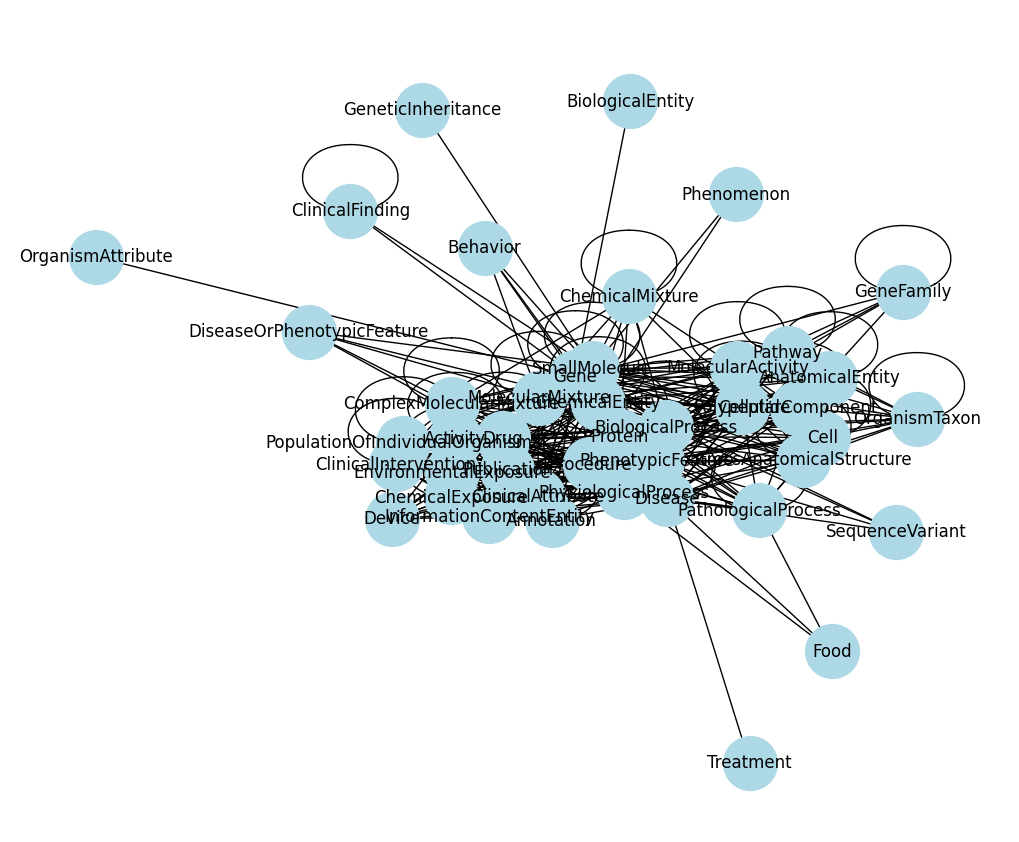

In [77]:
# Draw the graph using NetworkX and Matplotlib
pos = nx.spring_layout(new_graph)
# nx.draw_networkx_nodes(graph, pos, node_color='lightblue', node_size=500)
# nx.draw_networkx_edges(graph, pos, edge_color='gray')
# nx.draw_networkx_labels(graph, pos, font_size=10, font_family='Arial')
# nx.draw_networkx_edge_labels(graph, pos, font_size=8, font_family='Arial')
plt.figure(figsize=(10,8))
nx.draw(new_graph, with_labels=True, node_color='lightblue', node_size=1500, edge_cmap=plt.cm.Blues)#, pos = pos)
plt.title('New XML Graph (all predicates)')
plt.axis('off')
plt.show()

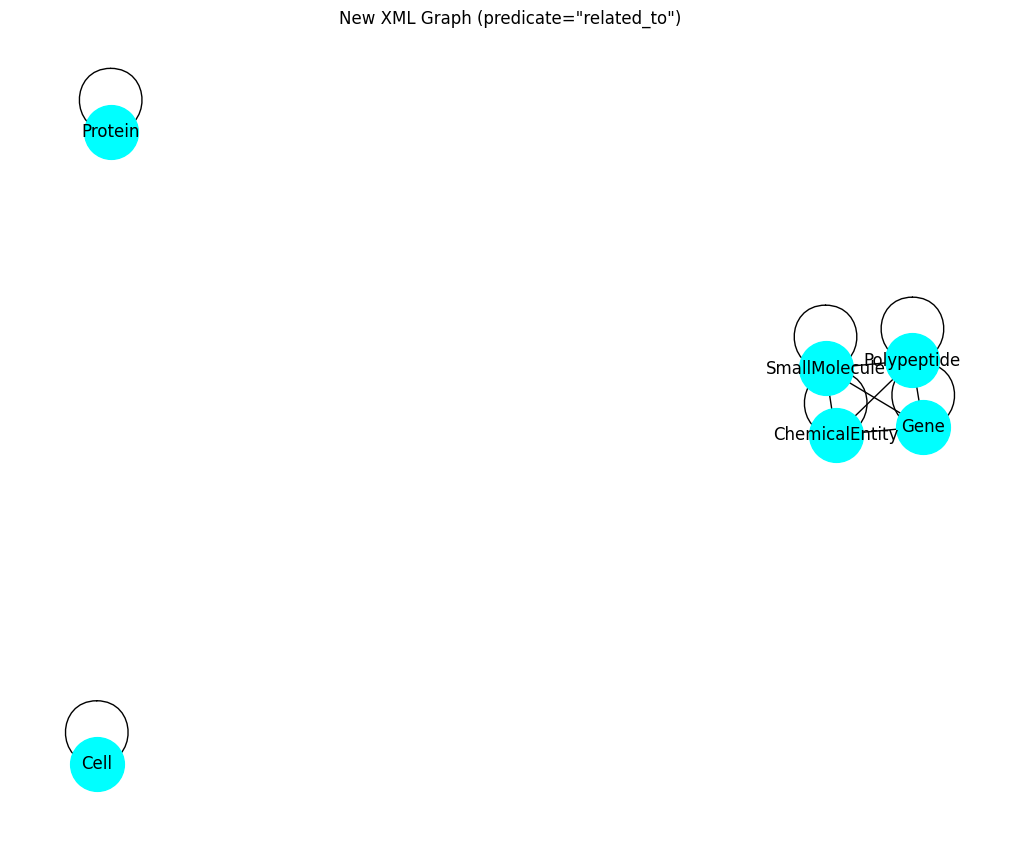

In [37]:
# Draw the graph using NetworkX and Matplotlib
pos = nx.spring_layout(new_graph2)
plt.figure(figsize=(10,8))
nx.draw(new_graph2, with_labels=True, node_color='cyan', node_size=1500, edge_cmap=plt.cm.Blues)#, pos = pos)
plt.title('New XML Graph (predicate="related_to")')
plt.axis('off')
plt.show()

### Visualize with `pyvis`

In [88]:
# !pip install pyvis


  Using cached pyvis-0.3.2-py3-none-any.whl (756 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached jsonpickle-3.0.1-py2.py3-none-any.whl (40 kB)
  Using cached MarkupSafe-2.1.2-cp310-cp310-macosx_10_9_x86_64.whl (13 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [92]:
from pyvis.network import Network


In [15]:
# net=Network(notebook=True)
# net.from_nx(new_graph2)
# net.show('testing.html')


---

### Build Function  
Build Notes:  
- functionality to provide XML output 
To-do:  
- replace pandas df w/ built-in function/ or not needed at all  


Build Methods 

In [77]:
# class MetaKGExport:


def list2xml(mkg_api, write_xml=False):
    """
    # Create a new XML document
    """

    root = ET.Element("graph")
    # Loop through the list of dictionaries
    for row in mkg_api:
        # Create the edge element
        edge = ET.SubElement(root, 'edge')
        # Set the source and target attributes
        edge.set('source', row['subject'])
        edge.set('target', row['object'])
        edge.set('relation', row['predicate'])

    # Create the XML tree
    tree = ET.ElementTree(root)
    if write_xml: 
        #logger.info("writing xml file %s"%xml_file)
        tree.write('graph_interacts_with.xml')

    return tree

def metakg_request(mkg_id):
    """
    Get MetaKG API:
    Using the query input ID, get the metakg api
    """
    api = SmartAPI.get(mkg_id)
    mkg_api = api.get_metakg()
    return mkg_api

# def filter_metakg(mkg_api, predicate):
#     """
#     Filter MetaKG API:
#     Filter the api, keeping data that corresponds to the query inputs
#     """
#     filtered_data = [api for api in mkg_api if api['predicate'] == predicate]
#     return filtered_data


def edges2graphml(edges, outfile=None):

     # Create the graphml element
    graphml = ET.Element("graphml", xmlns="http://graphml.graphdrawing.org/xmlns")

    # Add the edge keys
    edge_keys = ["subject", "predicate", "object"]
    for key_name in edge_keys:
        key = ET.SubElement(graphml, "key", id=key_name, for_="edge")
        key.set("attr.name", key_name)
        key.set("attr.type", "string")

    # Create the graph element
    graph = ET.SubElement(graphml, "graph", edgedefault="directed")

    # Add the edges
    for row in edges:
        edge = ET.SubElement(graph, 'edge')
        edge.set('source', row['subject'])
        edge.set('target', row['object'])
        edge.set('relation', row['predicate'])

    # Create the XML tree
    tree = ET.ElementTree(graphml)

    # Write the tree to the output file
    if outfile:
        tree.write(outfile)
    else:
        # Print the tree
        ET.dump(tree)
        
    return tree

In [64]:
# for testing
query_id ="dc91716f44207d2e1287c727f281d339"
predicate = 'interacts_with'
write_file = False
edges = metakg_request(query_id)


In [71]:
edges[1]

{'subject': 'SmallMolecule',
 'object': 'Disease',
 'predicate': 'contraindicated_for',
 'provided_by': None,
 'api': {'name': 'BioThings Explorer (BTE) TRAPI',
  'smartapi': {'metadata': 'https://raw.githubusercontent.com/NCATS-Tangerine/translator-api-registry/master/biothings_explorer/smartapi.yaml',
   'id': 'dc91716f44207d2e1287c727f281d339',
   'ui': 'https://smart-api.info/ui/dc91716f44207d2e1287c727f281d339'},
  'tags': ['1.3.0',
   'meta_knowledge_graph',
   'query',
   'asyncquery',
   'translator',
   'trapi',
   'biothings',
   'bte-trapi'],
  'x-translator': {'component': 'ARA', 'team': ['Exploring Agent']}},
 'bte': {'query_operation': {'path': '/query',
   'method': 'post',
   'server': 'https://bte.transltr.io/v1',
   'path_params': None,
   'params': None,
   'request_body': None,
   'support_batch': True,
   'input_separator': ','}}}

In [78]:
graphml_content = edges2graphml(edges)

<graphml xmlns="http://graphml.graphdrawing.org/xmlns"><key id="subject" for_="edge" attr.name="subject" attr.type="string" /><key id="predicate" for_="edge" attr.name="predicate" attr.type="string" /><key id="object" for_="edge" attr.name="object" attr.type="string" /><graph edgedefault="directed"><edge source="SmallMolecule" target="Disease" relation="treats" /><edge source="SmallMolecule" target="Disease" relation="contraindicated_for" /><edge source="SmallMolecule" target="Disease" relation="has_adverse_event" /><edge source="SmallMolecule" target="Disease" relation="occurs_together_in_literature_with" /><edge source="SmallMolecule" target="Disease" relation="associated_with" /><edge source="SmallMolecule" target="Disease" relation="related_to" /><edge source="SmallMolecule" target="Disease" relation="causes" /><edge source="SmallMolecule" target="Disease" relation="prevents" /><edge source="SmallMolecule" target="Disease" relation="affects" /><edge source="SmallMolecule" target="D

In [73]:
graphml_content = edges2graphml(edges,outfile="test_graphml.graphml")

In [6]:
# # Create the root element with the GraphML namespace
root = ET.Element("{http://graphml.graphdrawing.org/xmlns}graphml")

# Create the graph element with the Graph namespace
graph = ET.SubElement(root, "{http://graphml.graphdrawing.org/xmlns}graph")
graph.set("id", "G")
graph.set("edgedefault", "undirected")

# Create nodes and edges from the list_data
for data in mkg[:10]:
    subject = data["subject"]
    obj = data["object"]
    predicate = data["predicate"]

    # Create subject node
    subject_node = ET.SubElement(graph, "{http://graphml.graphdrawing.org/xmlns}node")
    subject_node.set("id", subject)

    # Create object node
    object_node = ET.SubElement(graph, "{http://graphml.graphdrawing.org/xmlns}node")
    object_node.set("id", obj)

    # Create edge between subject and object
    edge = ET.SubElement(graph, "{http://graphml.graphdrawing.org/xmlns}edge")
    edge.set("source", subject)
    edge.set("target", obj)

    # Set predicate as data for the edge
    predicate_data = ET.SubElement(edge, "{http://graphml.graphdrawing.org/xmlns}data")
    predicate_data.set("key", "predicate")
    predicate_data.text = predicate

# Create the XML tree
tree = ET.ElementTree(graph)

# Save the XML tree to a file
tree.write("example.graphml")
# indent/ format output directly with function 

Test graphml output

In [7]:
# testing
# Assume `tree` is your XML tree in GraphML format
root = tree.getroot()

# Try parsing the tree as a GraphML file
try:
    G = nx.read_graphml(root)
    print("The tree is in GraphML format!")
except nx.NetworkXError as e:
    print("Error:", e)

TypeError: expected str, bytes or os.PathLike object, not Element

---

1. Get MetaKG API (with query endpoint)  
2. Send it to GRAPHML  
    a. option to save as file


Testing:
write/graph



In [3]:

def xml2graphml(xml_tree, write_file=False):
    # Define the GraphML namespace
    graphml_ns = "http://graphml.graphdrawing.org/xmlns"
    # Create a new GraphML tree with the GraphML namespace
    graphml = ET.Element("{" + graphml_ns + "}graphml")
    # Add the GraphML key definitions for the node and edge attributes
    key1 = ET.SubElement(graphml, "key")
    key1.set("id", "name")
    key1.set("for", "node")
    key1.set("attr.name", "name")
    key1.set("attr.type", "string")

    key2 = ET.SubElement(graphml, "key")
    key2.set("id", "relation")
    key2.set("for", "edge")
    key2.set("attr.name", "relation")
    key2.set("attr.type", "string")
    
    # Create the graph element with the default directed attribute
    graph = ET.SubElement(graphml, "graph")
    graph.set("id", "G")
    graph.set("edgedefault", "directed")

    # Loop through the XML tree elements and create the corresponding GraphML elements
    for edge in xml_tree.findall(".//edge"):
        source = edge.get("source")
        target = edge.get("target")
        relation = edge.get("relation")

        node1 = ET.SubElement(graph, "node")
        node1.set("id", source)
        data1 = ET.SubElement(node1, "data")
        data1.set("key", "name")
        data1.text = source

        node2 = ET.SubElement(graph, "node")
        node2.set("id", target)
        data2 = ET.SubElement(node2, "data")
        data2.set("key", "name")
        data2.text = target

        edge = ET.SubElement(graph, "edge")
        edge.set("source", source)
        edge.set("target", target)
        data3 = ET.SubElement(edge, "data")
        data3.set("key", "relation")
        data3.text = relation

    # create an ElementTree object from the graphml_tree root
    graphml_tree = ET.ElementTree(graphml)

    # write the tree to a file
    if write_file: 
        # Assume that graphml_tree is the root element of your XML tree
        with open('graphml_test1.graphml', 'w') as f:
            # Set the encoding to 'UTF-8'
            f.write('<?xml version="1.0" encoding="UTF-8"?>\n')

            # Write the XML tree to the file with GraphML format
            graphml_tree.write(f, encoding='unicode', method='xml')
    return graphml_tree
def list2graphml(mkg_api):
    # Create a new GraphML document
    root = ET.Element("graphml")
    root.set("xmlns", "http://graphml.graphdrawing.org/xmlns")
    # Define the edge schema
    edge_schema = ET.SubElement(root, "key")
    edge_schema.set("id", "edge")
    edge_schema.set("for", "edge")
    edge_schema.set("attr.name", "relation")
    edge_schema.set("attr.type", "string")
    # Define the node schema
    node_schema = ET.SubElement(root, "key")
    node_schema.set("id", "node")
    node_schema.set("for", "node")
    node_schema.set("attr.name", "name")
    node_schema.set("attr.type", "string")
    # Create the graph element
    graph = ET.SubElement(root, "graph")
    graph.set("id", "G")
    # Loop through the list of dictionaries
    for row in mkg_api:
        # Create the node element
        node = ET.SubElement(graph, 'node')
        node.set('id', row['subject'])
        # Set the name attribute
        name_attr = ET.SubElement(node, 'data')
        name_attr.set('key', 'node')
        name = ET.SubElement(name_attr, 'name')
        name.text = row['subject']
        # Create the node element
        node = ET.SubElement(graph, 'node')
        node.set('id', row['object'])
        # Set the name attribute
        name_attr = ET.SubElement(node, 'data')
        name_attr.set('key', 'node')
        name = ET.SubElement(name_attr, 'name')
        name.text = row['object']
        # Create the edge element
        edge = ET.SubElement(graph, 'edge')
        edge.set('source', row['subject'])
        edge.set('target', row['object'])
        # Set the relation attribute
        relation_attr = ET.SubElement(edge, 'data')
        relation_attr.set('key', 'edge')
        relation = ET.SubElement(relation_attr, 'relation')
        relation.text = row['predicate']

    # Create the XML tree
    tree = ET.ElementTree(root)
    return tree

In [4]:
list2graphml()

TypeError: list2graphml() missing 1 required positional argument: 'mkg_api'

In [42]:
xml_tree = metakg2xml(query_id, predicate, write_file)

In [48]:
# import pydot
# from IPython.display import Image, display

# def visualize_xml_tree(xml_tree):
#     # Convert XML tree to DOT graph format
#     dot = ET.tostring(xml_tree, encoding='unicode')
#     # Create Pydot graph from DOT graph format
#     graph = pydot.graph_from_dot_data(dot)[0]
#     # Generate visualization of graph using Graphviz
#     display(Image(graph.create_png()))

# # Example usage:
# root = ET.Element("root")
# child1 = ET.SubElement(root, "child1")
# child2 = ET.SubElement(root, "child2")
# grandchild1 = ET.SubElement(child1, "grandchild1")
# grandchild2 = ET.SubElement(child1, "grandchild2")
# grandchild3 = ET.SubElement(child2, "grandchild3")
# xml_tree = ET.ElementTree(root)
visualize_xml_tree(xml_tree)

AttributeError: 'ElementTree' object has no attribute 'tag'

In [43]:
graphml_tree = xml2graphml(xml_tree, write_file=True)


In [45]:
# # Load the graphml file as a NetworkX graph object
# graph = nx.read_graphml('graphml_test1.graphml', node_type=str)

# # Draw the graph using the default layout algorithm
# nx.draw(graph, with_labels=True)
# plt.show()

---

 Graph and visualize

In [49]:
# Create an empty graph
new_graph = nx.Graph()

# Load the XML file
new_tree = ET.parse('graph_interacts_with.xml')
new_root = new_tree.getroot()

def fill_graph(graph,root):
    for child in root:
        if child.get('source'):
            source = child.get('source')
            target = child.get('target')
            relation = child.get('relation')
            # print(source, target, relation)
            graph.add_edge(source, target, relation=relation)

fill_graph(new_graph, new_root)


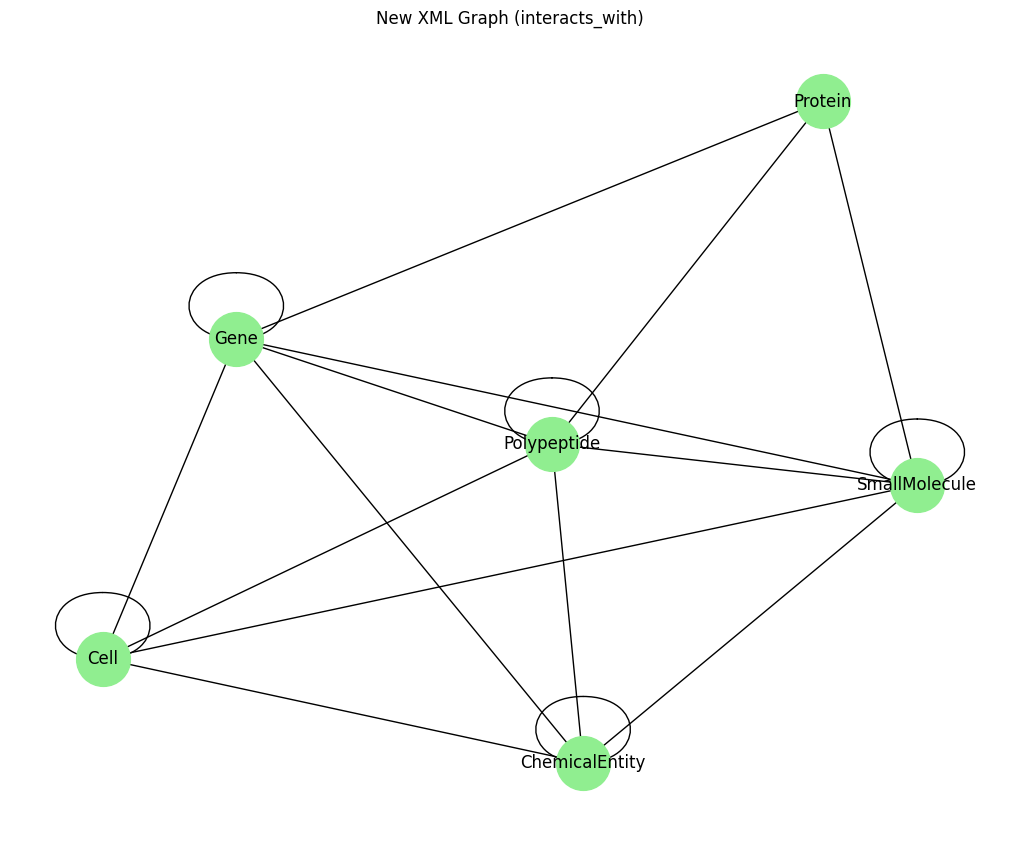

In [50]:
plt.figure(figsize=(10,8))
nx.draw(new_graph, with_labels=True, node_color='lightgreen', node_size=1500, edge_cmap=plt.cm.Blues)#, pos = pos)
plt.title('New XML Graph (interacts_with)')
plt.axis('off')
plt.show()

In [12]:
type(mkg_api), len(mkg_api)

(list, 2325)

In [13]:
mkg_api[0]

{'subject': 'SmallMolecule',
 'object': 'SmallMolecule',
 'predicate': 'interacts_with',
 'provided_by': None,
 'api': {'name': 'BioThings Explorer (BTE) TRAPI',
  'smartapi': {'metadata': 'https://raw.githubusercontent.com/NCATS-Tangerine/translator-api-registry/master/biothings_explorer/smartapi.yaml',
   'id': 'dc91716f44207d2e1287c727f281d339',
   'ui': 'https://smart-api.info/ui/dc91716f44207d2e1287c727f281d339'},
  'tags': ['1.3.0',
   'meta_knowledge_graph',
   'query',
   'asyncquery',
   'translator',
   'trapi',
   'biothings',
   'bte-trapi'],
  'x-translator': {'component': 'ARA', 'team': ['Exploring Agent']}},
 'bte': {'query_operation': {'path': '/query',
   'method': 'post',
   'server': 'https://bte.transltr.io/v1',
   'path_params': None,
   'params': None,
   'request_body': None,
   'support_batch': True,
   'input_separator': ','}}}

--- 
### Final Methods

In [ ]:

import logging
import xml.etree.ElementTree as ET

from controller import SmartAPI

logger = logging.getLogger("metakg_export")


# class MetaKGExport:
def write_graphml(tree, filename=None):
    """
    Output graphML file
    Input: 
        tree: graphml (xml) tree
        outfile: graphml file name, i.e "mygraph.graphml")
    Returns:
        Writes graphml file, else raises error.
    """
    if filename:
        tree.write(filename)
    else:
        print('[ERROR] no filename given')

def metakg_request(mkg_id, predicate=None):
    """
    Get MetaKG API
        - using built-in smartapi funcitons, get & return a datasets metakg api 
    Input:
        mkg_id: string id of the requested api
        predicate: (optional) string of a requested predicate, default none
    Returns: the requested mkg api data dictionaries in a list
    """
    api = SmartAPI.get(mkg_id)
    mkg_api = api.get_metakg()
    if predicate:
        return [d for d in mkg_api if d.get('predicate') == predicate]
    else:
        return mkg_api

def edges2graphml(edges, outfile=None):
    """
    Build a graphML (xml) tree
    Input:
        edges: list of dictionaries representing a knowledge graph with subject/object/predicate keys
        outfile: (optional) string filename to write the graphml tree to 
    Returns: a graphml (xml) tree -- will also write to file if outfile name passed
    """
    root = ET.Element('graphml')
    root.set('xmlns', 'http://graphml.graphdrawing.org/xmlns')

    # Define key for node data
    key_node = ET.SubElement(root, 'key')
    key_node.set('id', 'd1')
    key_node.set('for', 'node')
    key_node.set('attr.name', 'label')
    key_node.set('attr.type', 'string')

    # Define key for edge data
    key_edge = ET.SubElement(root, 'key')
    key_edge.set('id', 'd2')
    key_edge.set('for', 'edge')
    key_edge.set('attr.name', 'label')
    key_edge.set('attr.type', 'string')
    graph = ET.SubElement(root, 'graph')
    graph.set('id', 'G')
    graph.set('edgedefault', 'undirected') #'directed'

    # iterate over edges and fill in data
    for data in edges:
        node = ET.SubElement(graph, 'node')
        node.set('id', data['subject'])
        
        data_node = ET.SubElement(node, 'data')
        data_node.set('key', 'd1')
        data_node.text = data['subject']
        
        edge = ET.SubElement(graph, 'edge')
        edge.set('source', data['subject'])
        edge.set('target', data['object'])
        
        data_edge = ET.SubElement(edge, 'data')
        data_edge.set('key', 'd2')
        data_edge.text = data['predicate']

    tree = ET.ElementTree(root)
    if outfile:
        write_graphml(tree, outfile)
    
    return tree
